_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `capa_intermittency.dat` feeds the model with the dynamics of the Capacitor

In [3]:
data = np.genfromtxt('capa_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,0]

## Computing the Gradient

_Calculating the value of_ $\frac{dx}{dt}$

In [4]:
t_diff = 1
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)

1.0
1        0.000298
2        0.000298
3        0.000297
4        0.000297
5        0.000297
           ...   
9996     0.000018
9997     0.000018
9998     0.000018
9999     0.000018
10000    0.000018
Name: 0, Length: 10000, dtype: float64


## Loading Datasets

In [5]:
data = pd.read_csv("c5_interpolated_2300_100.csv")
training_set = data.iloc[:, 1]
training_set

0       89.140000
1       88.911429
2       88.682857
3       88.454286
4       88.225714
          ...    
2395    60.424213
2396    60.416287
2397    60.408362
2398    60.400437
2399    60.392512
Name: C5, Length: 2400, dtype: float64

In [6]:
test = training_set.tail(100)
test
training_set = training_set.head(2300)
training_set

0       89.140000
1       88.911429
2       88.682857
3       88.454286
4       88.225714
          ...    
2295     0.000000
2296     0.000000
2297     0.000000
2298     0.000000
2299     0.000000
Name: C5, Length: 2300, dtype: float64

In [7]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
print(gradient_t)

0       0.000298
1       0.000298
2       0.000297
3       0.000297
4       0.000297
          ...   
9995    0.000018
9996    0.000018
9997    0.000018
9998    0.000018
9999    0.000018
Name: 0, Length: 10000, dtype: float64


In [8]:
df = pd.concat((training_set, gradient_t), axis=1)
df.columns = ['y_t', 'grad_t']

In [9]:
df

,y_t,grad_t
0,89.140000,0.000298
1,88.911429,0.000298
2,88.682857,0.000297
3,88.454286,0.000297
4,88.225714,0.000297
...,...,...
9995,NaN,0.000018
9996,NaN,0.000018
9997,NaN,0.000018
9998,NaN,0.000018


## Plot of the External Forcing from Chaotic Differential Equation

<Axes: >

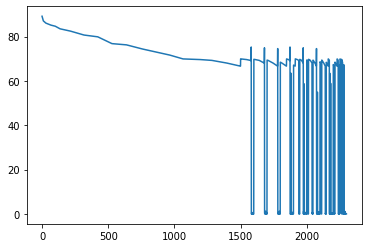

In [10]:
df.iloc[:, 0].plot()

C:\Users\Anurag Dutta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

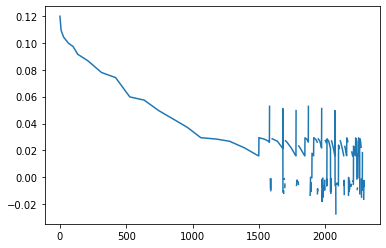

In [11]:
import numpy as np
c0 = 86.8407  # Value for C0
K0 = -0.0015  # Value for K0
K1 = -0.0001  # Value for K1
a = 0.0000    # Value for a
b = 0.0118    # Value for b
c = 2.5775    # Value for c

L = np.minimum(c0, (df.iloc[:, 1] - (df.iloc[:, 0] * (K0 - K1 * (9 * a * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c)**2 + 4 * b * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c) + c)))))
L.plot()

## Preprocessing the data into supervised learning

In [12]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [13]:
data = Supervised(df.values, n_in = 350, n_out = 100)


cols_to_drop = []
for i in range(2, 351):
    cols_to_drop.extend([f'var2(t-{i})'])

data.drop(cols_to_drop, axis=1, inplace=True)

print(data.head())
print(data.columns)

     var1(t-350)  var1(t-349)  var1(t-348)  var1(t-347)  var1(t-346)  \
350    89.140000    88.911429    88.682857    88.454286    88.225714   
351    88.911429    88.682857    88.454286    88.225714    87.997143   
352    88.682857    88.454286    88.225714    87.997143    87.768571   
353    88.454286    88.225714    87.997143    87.768571    87.540000   
354    88.225714    87.997143    87.768571    87.540000    87.311429   

     var1(t-345)  var1(t-344)  var1(t-343)  var1(t-342)  var1(t-341)  ...  \
350    87.997143    87.768571    87.540000    87.311429    87.095798  ...   
351    87.768571    87.540000    87.311429    87.095798    87.039776  ...   
352    87.540000    87.311429    87.095798    87.039776    86.983754  ...   
353    87.311429    87.095798    87.039776    86.983754    86.927731  ...   
354    87.095798    87.039776    86.983754    86.927731    86.871709  ...   

     var1(t+95)  var2(t+95)  var1(t+96)  var2(t+96)  var1(t+97)  var2(t+97)  \
350   79.161181    0.0002

In [14]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [15]:
trainy = train[:,-300:]
trainX = train[:,:-300]

In [16]:
forecasty = forecast[:,-300:]
forecastX = forecast[:,:-300]

In [17]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(1850, 1, 251) (1850, 300) (1, 1, 251)


In [18]:
C0 = tf.Variable(86.8407, name="C0", trainable=True, dtype=tf.float32)
K0 = tf.Variable(-0.0015, name="K0", trainable=True, dtype=tf.float32)
K1 = tf.Variable(-0.0001, name="K1", trainable=True, dtype=tf.float32)
a = tf.Variable(0.0000, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.0118, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(2.5775, name="c", trainable=True, dtype=tf.float32)

splitr = 0.8


def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    epsilon = 1
    squared_difference3 = tf.square(
        y_pred[:, 1] - (
            y_pred[:, 0] * (
                K0 - K1 * (
                    9 * a * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c)**2 +
                    4 * b * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c) + c
                )
            )
        )
    )
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(60))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
24/24 [==============================] - 3s 26ms/step - loss: 4983.4658 - val_loss: 3048.3250
Epoch 2/500
24/24 [==============================] - 0s 4ms/step - loss: 4730.0933 - val_loss: 2900.4126
Epoch 3/500
24/24 [==============================] - 0s 3ms/step - loss: 4604.7812 - val_loss: 2828.6235
Epoch 4/500
24/24 [==============================] - 0s 4ms/step - loss: 4500.3911 - val_loss: 2766.1660
Epoch 5/500
24/24 [==============================] - 0s 4ms/step - loss: 4401.8403 - val_loss: 2706.4514
Epoch 6/500
24/24 [==============================] - 0s 4ms/step - loss: 4306.6343 - val_loss: 2648.8235
Epoch 7/500
24/24 [==============================] - 0s 5ms/step - loss: 4214.0088 - val_loss: 2592.9412
Epoch 8/500
24/24 [==============================] - 0s 4ms/step - loss: 4123.5571 - val_loss: 2538.6055
Epoch 9/500
24/24 [==============================] - 0s 4ms/step - loss: 4034.9321 - val_loss: 2481.1367
Epoch 10/500
24/24 [==============================] - 

In [19]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 1s 552ms/step


In [20]:
forecastX.shape

(1, 1, 251)

In [21]:
forecast_without_mc.shape

(1, 251)

In [22]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [23]:
inv_yhat_without_mc.shape

(1, 311)

In [24]:
fforecast = inv_yhat_without_mc[:,-300:]

In [25]:
fforecast.shape

(1, 300)

In [26]:
final_forecast = fforecast[:,0:300:3]

In [27]:
fforecast.shape

(1, 300)

In [28]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [29]:
final_forecast

array([[6.96110177e+01, 6.95110177e+01, 6.94109337e+01, 6.93084967e+01,
        7.52695465e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.03557104e-01, 2.64017493e-01, 0.00000000e+00,
        0.00000000e+00, 6.71128151e+01, 6.69867647e+01, 6.68607143e+01,
        6.67346639e+01, 6.66512605e+01, 6.98683940e+01, 6.98179739e+01,
        6.97675537e+01, 6.97171335e+01, 6.96334267e+01, 6.95332586e+01,
        6.94321746e+01, 6.93330906e+01, 6.91076797e+01, 4.68572617e-01,
        0.00000000e+00, 6.96745098e+01, 6.95736695e+01, 6.94728291e+01,
        6.93719888e+01, 6.92206583e+01, 6.89433473e+01, 6.86660364e+01,
        6.83887255e+01, 6.80792017e+01, 5.82197547e-01, 4.10423160e-01,
        0.00000000e+00, 0.00000000e+00, 2.45603120e-02, 0.00000000e+00,
        0.00000000e+00, 1.09320723e-01, 0.00000000e+00, 6.93553315e+01,
        6.91693044e+01, 0.00000000e+00, 3.39738905e-01, 6.96969188e+01,
        6.95960784e+01, 6.94952381e+01, 6.93943978e+01, 6.928228

In [30]:
final_forecast.shape

(1, 100)

In [31]:
test.shape

(100,)

In [32]:
training_set = np.array(training_set)
test = np.array(test)
final_forecast = np.array(final_forecast.squeeze(0))

In [33]:
test

array([61.17709913, 61.16917401, 61.16124889, 61.15332377, 61.14539865,
       61.13747353, 61.1295484 , 61.12162328, 61.11369816, 61.10577304,
       61.09784792, 61.0899228 , 61.08199768, 61.07407256, 61.06614743,
       61.05822231, 61.05029719, 61.04237207, 61.03444695, 61.02652183,
       61.01859671, 61.01067159, 61.00274646, 60.99482134, 60.98689622,
       60.9789711 , 60.97104598, 60.96312086, 60.95519574, 60.94727062,
       60.93934549, 60.93142037, 60.92349525, 60.91557013, 60.90764501,
       60.89971989, 60.89179477, 60.88386965, 60.87594452, 60.8680194 ,
       60.86009428, 60.85216916, 60.84424404, 60.83631892, 60.8283938 ,
       60.82046868, 60.81254355, 60.80461843, 60.79669331, 60.78876819,
       60.78084307, 60.77291795, 60.76499283, 60.75706771, 60.74914258,
       60.74121746, 60.73329234, 60.72536722, 60.7174421 , 60.70951698,
       60.70159186, 60.69366673, 60.68574161, 60.67781649, 60.66989137,
       60.66196625, 60.65404113, 60.64611601, 60.63819089, 60.63

In [34]:
test.shape

(100,)

In [35]:
final_forecast.shape

(100,)

In [36]:
test.shape

(100,)

In [37]:
import math
MSE = np.square(np.subtract(np.array(test),np.array(final_forecast))).mean()   
rsme = math.sqrt(MSE)
print(rsme)  
MAE = np.abs(np.subtract(np.array(test),np.array(final_forecast))).mean()   
mae = MAE
print(mae)

43.15843877866673
34.253890626818254
